<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение данных из файла</a></span></li><li><span><a href="#Подготовка-данных-перед-построением-модели" data-toc-modified-id="Подготовка-данных-перед-построением-модели-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных перед построением модели</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Построение-моделей-без-учета-дисбаланса-классов" data-toc-modified-id="Построение-моделей-без-учета-дисбаланса-классов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Построение моделей без учета дисбаланса классов</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-весов" data-toc-modified-id="Взвешивание-весов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание весов</a></span></li><li><span><a href="#Увеличение-выборки-(upsampling)" data-toc-modified-id="Увеличение-выборки-(upsampling)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки (upsampling)</a></span></li><li><span><a href="#Уменьшение-выборки-(downsampling)." data-toc-modified-id="Уменьшение-выборки-(downsampling).-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Уменьшение выборки (downsampling).</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Изучение данных из файла

В самом начале импортируем все необходимые библиотеки

In [1]:
import pandas as pd


from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve 

from sklearn.model_selection import GridSearchCV

from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score


In [2]:
df =  pd.read_csv('/datasets/Churn.csv') # открытие файла

In [3]:
display(df.head()) # просмотр первых 5 строк

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


По первым пяти строкам можно сказать, что не все данные нам будут нужны для обучения модели, например фамилия человека для предсказаний не имеет никакого значения, как и его идентификационный номер. Столбец с фамилиями и номер строки мы точно удалим, а уникальный номер клиента переведем в индекс - Sklearn не использует столбец с индексом при обучении модели.

Еще мы видим, что в файле разброс числовых значений разный, например у возраста, баланса на счете, предпрогаемая з/п, количество банковских продуктов и количество лет, в течении которых человек был клиентом банка. Данные необходимо масштабировать.

Посмотрим общую информацию о файле

In [4]:
df.info() # просмотр информации о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В таблице 14 столбцов. В 3-х тип данных float64, в восьми - int64 и в 3-х - object. В столбце с количеством лет, которое человек был клиеном банка есть пропуски. 

В соответствии с документацией в файле есть следующие данные:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента (целевой признак)

Проверим, нет ли полностью дублирующихся строк:

In [5]:
df.duplicated().sum() # подсчет количества дублирующихся строй

0

Полностью дублирующихся строк не обнаружено. Проверим количество уникальных значений в столбцах со страной проживания и полом клиента.

In [6]:
df['Geography'].unique() # просмотр уникальных значений

array(['France', 'Spain', 'Germany'], dtype=object)

In [7]:
df['Gender'].unique() # просмотр уникальных значений

array(['Female', 'Male'], dtype=object)

Стран всего три, а в графе с полом нет никаких неожиданностей, только женский и мужской пол.

У нас остались только не исследованы пропуски в графе со сроком, в течении которого человек был клиентом банка. Посмотрим 10 строк.

In [8]:
display((df.loc[df['Tenure'] != df['Tenure']]).head(10)) # используем логическую индексацию для поиска нужных строк

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Люди разных возрастов, из разных стран, разных полов и т.д. У них нет ни одного очевидного признака, который бы их объединил и объяснил отсутствие информации о пропусках в столбе Tenure. Предположу, что это скорее всего техническая ошибка при выгрузке данных. К сожалению, восстановить данную информацию без помощи сотрудников банка, не представляется возможным. Как подсказывает мне мой опыт в этой области, а также опыт моих коллег связь между тем сколько лет человек является клиентом банка и вероятностью его ухода, достаточно слабая при прочих равных условиях.

**Вывод**


Первый анализ данных показал:
- в таблице есть столбцы, которые нам не потребуются для построения модели. Их мы можем удалить.
- полных дубликатов строк нет
- в таблице есть категориальные значения: страна и пол человека. Их мы преобразуем с помошью прямого кодирования.
- в столбце с количеством лет, которое человек был клиеном банка есть пропуски. Заполнять пропуски мы не будем, т.к у нас нет адекватной информации, через которую мы могли бы сами вычислить срок и нет возможности обратиться к сотрудникам банка. Этот столбец мы исключим из данных.
- в данных есть количественные признаки с разным разбросом значений. Чтобы избежать ловушки, когда модель решит, что чем больше признак, тем он важнее, мы должны провести масштабирование.

### Подготовка данных перед построением модели

В этом разделе мы удалим ненужные столбцы; преобразуем категориальные значения в числовые прямым кодированием; масштабируем количественные признаки; разделим выборку на три части: обучающую, валидационную и тестовую; в конце выделим в каждой выборке признаки и целевой признак.

In [9]:
сhurn = df.drop(['Surname', 'RowNumber', 'Tenure'], axis =1) # удаляем столбцы

Столбик с уникальным идентификатором клиента мы преобразуем в индекс, т.к. для построения модели он не нужен, но есть вероятность, что в какой-то момент, нам нужно будет восстановить данные о каких-то клиентах.

In [10]:
сhurn = сhurn.set_index('CustomerId') # преобразовываем значения столбца в индексы

In [11]:
display(сhurn.head()) # просмотр результата преобразования на примере первых 5 строк

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,
15634602,619,France,Female,42,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,125510.82,1,1,1,79084.10,0


В наших данных есть два столбца с категориальными признаками: пол и страна проживания клиента. В столбце с полом у нас два варианта ответа: либо клиент женщина, либо мужчина. Стран проживания у нас три. Если мы просто выполним прямое кодирование, то получим несколько дополнительных взаимосвязанных столбца, например поскольку у нас в графе пол, только два варианта, то нет смысла под каждый создавать столбец. В графе страна проживания три варианта ответа, а если в таблицу добавились три новых столбца, сильно связанных между собой, один из них можно не добавлять. Восстановить столбец можно по оставшимся двум. Чтобы не попасть в дамми-ловушку мы добавим параметр drop_first=True, который удалит первый из образовавшихся новых столбцов. 

In [12]:
сhurn_ohe = pd.get_dummies(сhurn, drop_first=True) #преобразование категориальных признаков методом прямого кодирования

In [13]:
display(сhurn_ohe.head()) # просмотр первых 5 строк

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,
15634602,619,42,0.00,1,1,1,101348.88,1,0,0,0
15647311,608,41,83807.86,1,0,1,112542.58,0,0,1,0
15619304,502,42,159660.80,3,1,0,113931.57,1,0,0,0
15701354,699,39,0.00,2,0,0,93826.63,0,0,0,0
15737888,850,43,125510.82,1,1,1,79084.10,0,0,1,0


Разделим выборку на признаки (features) и целевой признак (target).

In [14]:
target = сhurn_ohe['Exited'] #целевой признак
features = сhurn_ohe.drop('Exited', axis=1) # признаки


Для начала нам необходимо разделить данные на три части: на обучающую, валидационную и тестовую выборки. Обучающая выборка будет самой большой и вместит 60% данных. С помощью нее мы будем обучать модель. Вторая выборка валидационная (20% от объема данных), нужна нам для проверки качества работы алгоритма во время обучения модели. И последняя третья выборка - тестовая. Ее размер 20% от общего объема данных. На ней мы будем проверять качество обученной модели. Для начала извлечем из общего набора 40% данных, которые потом поделим попалам и одна часть будет у нас валидационной выборкой, а вторая тестовой.

In [15]:
features_train, features_valid_test, target_train, \
 target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)

In [16]:
features_valid, features_test, target_valid, \
 target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [17]:
display(features_train.shape)
display(target_train.shape)

(6000, 10)

(6000,)

In [18]:
display(features_valid.shape)
display(target_valid.shape)

(2000, 10)

(2000,)

In [19]:
display(features_test.shape)
display(target_test.shape)

(2000, 10)

(2000,)

Разделение выборки выполнено успешно. Далее перейдем к масштабированию признаков. Выберем те столбцы, которые будем масштабировать и запишем их в переменную. Затем обучим scaler на обучающей выборке и только потом его применим к валидационной и тестовой выборкам.

In [20]:
pd.options.mode.chained_assignment = None

numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])



display(features_train.head())


,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,
15671987,-0.886751,-0.373192,1.232271,-0.891560,1,0,-0.187705,0,1,1
15815628,0.608663,-0.183385,0.600563,-0.891560,0,0,-0.333945,0,0,0
15799494,2.052152,0.480939,1.027098,0.830152,0,1,1.503095,1,0,1
15711288,-1.457915,-1.417129,-1.233163,0.830152,1,0,-1.071061,0,0,1
15699492,0.130961,-1.132419,1.140475,-0.891560,0,0,1.524268,1,0,0


**Вывод**


В этом разделе мы выполнили все преобразования, которые нужны для дальнейшего построения моделей.
- удалили ненужные столбцы
- обработали категориальные значения методом прямого кодирования и при этом постарались избежать дамми-ловушек
- масштабировали количественные данные

## Исследование задачи

### Построение моделей без учета дисбаланса классов

Целевой признак у нас категориальный, поэтому нам предстоит решить задачу классификации. В этом разделе мы построим три модели: решающее дерево, случайный лес и логистическую регрессию без учета дисбаланса классов.

DecisionTreeClassifier - это структура для классификации деревом решений. В переменной model будет хранится наша модель. А чтобы запустить обучение вызовем метод fit(), которому передадим наши признаки и целевой признак. После обучения, вызовем метод predict() и передадим ему валидационную выборку для проверки работоспособности модели.

Поскольку от глубины дерева, будет зависеть как обучится модель, то попробуем в цикле подобрать оптимальную глубину дерева. Глубина дерева задается параметром max_depth. Решающее дерево легко переобучается, поэтому не стоит делать глубину очень большой. Оценивать, как обучилась модель будем по таким меткикам качества, как F1-мера и AUC-ROC. F1-мера является агрегирующей метрикой, которая является средим гармоническим полноты (recall) и точности (precision). Метрика AUC (площадь под графиком ROC-кривой) оценивает качество работы классификатора, вычисляющего вероятность принадлежности объекта к положительному классуЧем выше эти показатели, тем лучше обучилась модель.

In [21]:
best_model = None
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result 

print("F1:", best_result,';' "max_depth =", depth)
    

F1: 0.5528700906344411 ;max_depth = 5


In [22]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8221680508592478


Лучший результат показало дерево с глубиной max_depth = 5. Величина F1 0.5528, а  AUC 0,8222

Еще один алгоритм - случайный лес. Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Алгоритм случайного леса - RandomForestClassifier. Чтобы управлять количеством деревьев, есть параметр n_estimators. Чем больше деревьев, тем лучше результат, но модель будет учится дольше.

In [23]:
best_model = None
best_result = 0
for est in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result 

print("F1:", best_result,';' "Число деревьев:", est)

F1: 0.5939741750358679 ;Число деревьев: 49


In [24]:
model = RandomForestClassifier(random_state=12345, n_estimators=49)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

AUC-ROC: 0.828087666874346


Лучший результат показал лес из 49 деревьев. Величина F1 0.5940, а  AUC 0,8280

Последним посмотрим такой алгоритм, как логистическую регрессию (LogisticRegression). Эта модель хороша, тем, что вероятность переобучения не велика, но при этом качество обучения у нее хуже, чем у случайного леса.

In [25]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)

#print("Accuracy модели на валидационной выборке:", accuracy_score(target_valid, predicted_valid)) 
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.3247863247863248
AUC-ROC: 0.7576700197799406


Хуже всего результат у логистической регрессии. Величина F1 0.3248, а AUC 0,7577

Показатели AUC достаточно неплохие, но F1-мера больше 0,59, только у случайного леса. Насколько адекватен этот результат? Когда мы имеем дело с равными классами, то обучение модели идет равномерно. В случае с неравномерными классами модель при обучении воспринимает больший класс, как более важный и обучается неверно. Посмотрим баланс классов.

0    0.800667
1    0.199333
Name: Exited, dtype: float64


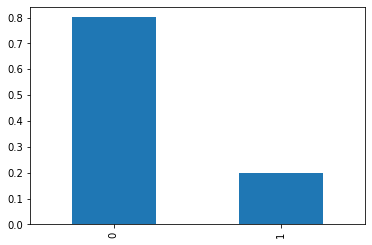

In [26]:
class_exited = target_train.value_counts(normalize=True)
print(class_exited)
class_exited.plot(kind='bar')
plt.show()

Количество клиентов покинувших банк всего 19,9%. Налицо дисбаланс классов. Дисбаланс приводит к появлению ложного впечатления о повышении точности модели, так как входные данные смещены в сторону одного класса и это смещение отражается на обученной модели.

**Вывод**

В этом разделе мы построили три модели: решающее дерево, случайный лес и логистическую регрессию. Посчитали F1-меру и AUC-ROC для каждой из моделей. Лучший результат дал случайный лес с 49 деревьями. Но поскольку модель, обученная на несбалансированных данных дает неадекватные предсказания, мы проверили насколько сбалансироавны наши данные. Расчет показал, что у нас наблюдается дисбаланс данных. Следовательно модели построенные в этом разделе не пригодны для хорошего предсказания целевого признака.

## Борьба с дисбалансом

Для борьбы с дибалансов в своей работе мы применим три метода: взвешивание классов, увеличение выборки и уменьшение выборки. В каждом из трех случаев мы будем строить три модели: решаюшее дерево, случайный лес и логистическую регрессию. Для оценки качества модели мы расчитаем такой показатель, как F1-мера. 

F1-мера является агрегирующей метрикой, которая является средим гармоническим полноты (recall) и точности (precision). 

### Взвешивание весов

При построении моделей по умолчанию считается, что вес класса "0" и "1" одинаковый. В случае с дисбалансом нам если все оставить как есть, модель будет считать тот класс важнее, чей вес больше. Чтобы этого избежать нужно указать аргумент class_weight='balanced' .

Постоим модель с помощью решающего дерева и посчитаем F1-меру и AUC-ROC.

In [27]:
best_model = None
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result 
print("F1:", best_result,';' "max_depth =", depth,)



F1: 0.5963791267305644 ;max_depth = 5


In [28]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8310244134068074


Лучший результат показало дерево с max_depth = 5. Далее мы не будем делать подбор глубины дерева, а будем использовать глубину указанную как лучшую при постоении этой модели (мы уже дважды получили этот результат как лучший)

Следующей постоим модель случайного леса. Для подбора лучших гиперпараметров применим GridSearchCV. Гиперпараметры, которые мы будем подбирать - это количество деревьев и глубина деревьев. В отличие от решающего дерева, где глубина должна быть не очень большой, а то модель сильно переучится, в случайном лесе наоборот рекомендуют применять большое количество деревьев с большой глубиной (т.е. большое количество по сути переученных деревьев).

In [29]:
clf = RandomForestClassifier(random_state=12345)
parametrs = { 'n_estimators': range (10, 100, 10),
              'max_depth': range (1,20, 1),
            }
grid = GridSearchCV(clf, parametrs, cv = None)
grid.fit(features_train, target_train)
print(grid.best_params_)

{'max_depth': 8, 'n_estimators': 90}


Лучшее соотношение - это 90 деревьев с глубиной 8. Применим величины этих гиперпараметров и построим модель.

In [30]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=8, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.6267682263329706
AUC-ROC: 0.8558597317912641


Результат лучше, чем у решающего дерева. Теперь посмотрим логистическую регрессию:

In [31]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.4875536480686695
AUC-ROC: 0.7626089560183645


Опять у логистической регрессии самый низкий результат.

**Вывод**


Взвешивание весов позволило нам обучить модели так, что показатели F1-меры и AUC-ROC стали больше, чем у моделей, построенных без учета дисбаланса. 
- Для решающего дерева F1-мера увеличилась с 0,5528 до 0,5964, а AUC увеличилась с 0,8222 до 0,8310. 
- Для случайного леса F1-мера увеличилась с 0,5940 до 0,6268, а AUC увеличилась с 0,8280 до 0,8559.
- Для логистической регрессии F1-мера увеличилась с 0,3248 до 0,4876, а AUC увеличилась с 0,7577 до 0,7626.

### Увеличение выборки (upsampling)

Еше одним методом борьбы с дисбалансом является upsampling. Суть его в том, чтобы разделить выборку по классам, а потом скопировать выборку с меньшим классом столько раз, сколько нужно для того, чтобы ее размер стал примерно такой же как размер выборки с большим классом. Затем выборки объединяют, перемешивают и данные готовы к построению модели. 

In [32]:
def upsample(features_train, target_train, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    repeat = 3
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled 


features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)

(8392, 10)
(8392,)


С учетом увеличенния выборки построим модель с помощью решающего дерева с глубиной 5.

In [33]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
    
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.586374695863747
AUC-ROC: 0.8229097986317362


F1-мера равна 0,5863, а AUC равен 0,8229, что меньше, чем при взвешивании весов. Теперь посмотрим на случайный лес с глубиной 8 и количеством деревьев 90.

In [34]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=8)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.6293706293706294
AUC-ROC: 0.8544858727671955


F1-мера 0,6294, AUC 0,8545. Пока это лучший результат на валидационной выборке. Далее логистическая регрессия:

In [35]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.5
AUC-ROC: 0.7616456668622482


F1-мера 0,5, AUC 0,7616. Величина F1-меры выше, чем у этого же вида модели при взвешивании весов, но все равно не достаточная.

### Уменьшение выборки (downsampling).

Downsampling похож по на upsampling, с той разницей, что мы вместо увеличения меньшего класса, делаем уменьшение большего класса. Т.е. мы опять делим выборку на два класса и больший уменьшаем до размера меньшего, затем объединяем и перемешиваем данные. Данный метод хорош, когда данных в достатке, на малом количестве лучше не использовать. Наша выборка не велика, но мы все равно попробуем применить downsampling, для чистоты эксперимента.

In [36]:
def downsample(features_train, target_train, fraction):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2637, 10)
(2637,)


От нашей первоначальной обучающей выборки осталось меньше половины данных. Попробуем постоить модель с помошью решающего дерева.

In [37]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
    
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.579212916246216
AUC-ROC: 0.8141109007434112


На валидационной выборке в данном случае величина f1-меры 0,5792, что меньше, чем предыдущие два результата. 

In [38]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=8)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.615859938208033
AUC-ROC: 0.8538310780974963


У случайного леса тоже величина F1-меры меньше, чем в предыдущих аналогичных моделях. Всего 0,6159

In [39]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

F1: 0.49810606060606055
AUC-ROC: 0.7631639436483405


F1-мера 0,4981, AUC 0,7632. У логистической регрессии результат AUC получился выше, чем во всех моделях этого вида.

**Вывод**


В данном разделе мы боролись с дисбалансом классов. Мы применили следующие методы: взвешивание классов, увеличение выборки и уменьшение выборки. Для каждого из методов мы постоили три модели: решаюшее дерево, случайный лес и логистическую регрессию. Для каждой модели посчиталь такую метрику качества как F1-меру и AUC-ROC. Результат получился следующий:
- наибольший показатель F1-меры дала модель, построенная с помощью случайного леса с глубиной деревьев 8 и количеством деревьев 90, в которой для борьбы с дисбалансом использовалось увеличение обучающей выборки (upsampling).
- логистическая регрессия во всех трех случаях давала низкое значение F1-меры.
- в целом все три модели дали лучшие значения F1-меры при увеличении выборки, для борьбы с дисбалансом



Для трех видов моделей на основе двух метрик качества вместе (F1-меры и AUC-ROC) можно сказать следующее:
- для решающего дерева лучший результат дала борьба с дисбалансом путем взвешивания весов. F1-мера 0,5964 и AUC-ROC 0,8310
- для случайного леса лучший результат дала борьба с дисбалансом путем увеличения выборки. F1-мера 0,6294 и AUC-ROC 0,8545
- для логистической регрессии увеличение выборки и уменьшение дало примерно одинаковые результаты: при увеличении выборки F1-мера 0,5 и AUC-ROC 0,7616; при уменьшении выборки F1-мера 0,4981 и AUC-ROC 0,7632. 

## Тестирование модели

Для того чтобы проверить работоспособность уже обученной модели, проверим ее на тестовой выборке. Если модель обучилась достаточно хорошо и нет переобучения и недообучения, то показатель F1-меры на тестовой выборке будет близок к показателю F1-меры на валидационной выборке.

В предыдущем разделе лучшей признали модель, обученную с помощью случайного леса с глубиной деревьев 8 и количеством деревьев 90. Для борьбы с дисбалансов использовалось увеличение обучающей выборки (upsampling).

In [40]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=8)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.6111111111111112


Показатель F1-меры обученной модели на тестовой выборки чуть ниже, чем на валидационной, но не значительно.

Вычисляем AUC-ROC (площадь под кривой ошибок) для тестовой части модели, чтобы определить ее качество.

AUC-ROC: 0.8588426119558487


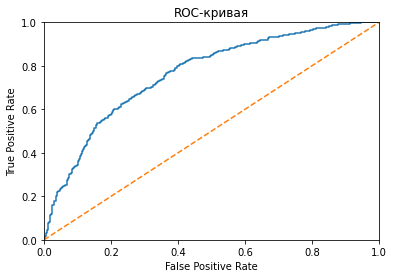

In [41]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=8)
model.fit(features_upsampled, target_upsampled)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("AUC-ROC:", auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая') 

plt.show()

Чем больше значение AUC, тем «лучше» модель классификации. При прогнозировании вероятности чем больший мы можем получить TPR при меньшем FPR, тем лучше качество классификатора. Метрика AUC (площадьпод графиком ROC-кривой) оценивает качество работы классификатора, вычисляющего вероятность принадлежности объекта к положительному классу. Если AUC -1, то модель идеально определяет классы. В нашем случае показатель 0,8588 - это достаточно хорошо, но пока не идеально.

## Общий вывод

В данном проекте мы попытались построить модель, которая на основе данных банка предсказывала бы уйдет клиент из банка в ближайшее время или нет.

В первой части проекта мы изучили данные из файла и определили какую предобработку необходимо сделать. В этой же части проекта мы:
- удалили ненужные столбцы
- обработали категориальные значения методом прямого кодирования и при этом постарались избежать дамми-ловушек
- масштабировали количественные данные

В самом конце первого раздела, мы разделили данные на признаки и целевой признак, а также поделили выборку на три части: обучающую (60%), валидационную (20%) и тестовую (20%)

Во втором разделе проекта мы построили три модели: решающее дерево, случайный лес и логистическую регрессию без учета дисбаланса классов. Для каждой модели расчитали F1-меру и AUC-ROC. Лучший результать F1-меры и AUC-ROC на валидационной выборки получен в моделе построенной случайным лесом с количеством деревьев 49. Также в этом разделе мы обнаружили дисбаланс классов и признали наши модели построенные без учета этого дисбаланса непригодными.

Для моделей без учета дисбаланса мы получали следующие метрики качества:
- решающее дерево F1-мера 0,5528 и AUC-ROC 0,8222
- случайный лес F1-мера 0,5940 и AUC-ROC 0,8280
- логистическая регрессия F1-мера 0,3248 и AUC-ROC 0,7577

В третьем пункте мы боролись с дисбалансом классов. Мы применили следующие методы: взвешивание классов, увеличение выборки и уменьшение выборки. Для каждого из методов мы постоили три модели: решаюшее дерево, случайный лес и логистическую регрессию. Для каждой модели посчиталь такую метрику качества как F1-меру. Результат получился следующий:

- наибольший показатель F1-меры дала модель построенная с помощью случайного леса с глубиной деревьев 8 и количеством - деревьев 90, в которой для борьбы с дисбалансом, использовалось увеличение обучающей выборки (upsampling).
- логистическая регрессия во всех трех случаях давала низкое значение F1-меры.
- в целом все три модели дали лучшие значения F1-меры при увеличении выборки, для борьбы с дисбалансом
- применение downsampling привело к тому, что обучающая выборка стала очень мала. Несмотря на то, что показатель F1-меры получился неплохой, считаю нецелесообразным использовать все три модели построенные на уменьшенной выборке, т.к. возможно недообучение и на новых данных готовая модель будет плохо работать.

Для трех видов моделей на основе двух метрик качества вместе (F1-меры и AUC-ROC) можно сказать следующее:
- для решающего дерева лучший результат дала борьба с дисбалансом путем взвешивания весов. F1-мера 0,5964 и AUC-ROC 0,8310
- для случайного леса лучший результат дала борьба с дисбалансом путем увеличения выборки. F1-мера 0,6294 и AUC-ROC 0,8545
- для логистической регрессии увеличение выборки и уменьшение дало примерно одинаковые результаты: при увеличении выборки F1-мера 0,5 и AUC-ROC 0,7616; при уменьшении выборки F1-мера 0,4981 и AUC-ROC 0,7632. 

В четвертом разделе мы проводили тестирование нашей лучшей модели - модели построенной с помощью случайного леса с глубиной деревьев 8 и количеством - деревьев 90, в которой для борьбы с дисбалансом, использовалось увеличение обучающей выборки (upsampling).

F1-мера равна 0,61. Это значение выше, чем 0,59, которое было указано как минимальное в задании. 

Также в этом разделе мы построили ROC-кривую и расчитали AUC-ROC. Результат 0,8588 - это достаточно хорошо, но пока не идеально.